In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import glob
import os
import numpy as np
import pandas as pd
import sys
import cv2
from sklearn.metrics import confusion_matrix

In [2]:
class FaceImage(Dataset):
    def __init__(self,label,picture_file,path,Train=True):
        self.data_path = path
        self.label = label
        self.train = Train
        self.picture_file = picture_file
    def __getitem__(self,index):

        file_path = os.path.join(self.data_path,self.picture_file[index])
        img = cv2.imread(file_path,cv2.IMREAD_GRAYSCALE)
        img = np.expand_dims(img,0)
        img =torch.tensor(img).float()
        if self.train==True:
            return torch.FloatTensor(img),self.label[index,1]
        else:
            return img

    def __len__(self):
        return len(os.listdir(self.data_path))


In [3]:
class ImageNet(nn.Module):
    def __init__(self):
        super(ImageNet,self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 48, kernel_size=3,stride =(1,1)),
            nn.Dropout2d(0.3),
            nn.MaxPool2d(2),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(48, 128, kernel_size=3,stride =(1,1)),
            nn.Dropout2d(0.2),
            nn.MaxPool2d(2),
            nn.ReLU()
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3,stride =(1,1)),
            nn.Dropout2d(0.5),
            nn.MaxPool2d(2),
            nn.ReLU()
        )

        self.fcn1 = nn.Linear(in_features =4096 ,out_features =512 ,bias = True)
        self.fcn2 = nn.Linear(in_features = 512,out_features =256 ,bias = True)
        self.fcn3 = nn.Linear(in_features =256 ,out_features =7 ,bias = True)

    def forward(self , x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size(0),-1)
        #print("size:",x.shape)
        x = F.relu(self.fcn1(x))
        x = F.relu(self.fcn2(x))
        out = self.fcn3(x)
        
        return out

In [4]:
train_label = pd.read_csv('./train.csv')
train_label = np.array(train_label,dtype = int)
datalen  = len(train_label)
picture_file = sorted(os.listdir('./train_img'))
train_dataset = FaceImage(train_label,picture_file,'./train_img')
picture_file = sorted(os.listdir('./test_img'))
test_dataset = FaceImage(train_label,picture_file,'./test_img',Train = False)
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size = 256)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size =256)

In [105]:
model = torch.load("Imagenet.pkl",map_location = "cpu")

In [106]:
model.eval()
pre = []
ans = []
for batch_index ,(data, label) in enumerate(train_loader):
    print(batch_index)
    pre.append(model(data))
    ans.append(label)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112


In [107]:
pre_final = []
ans_final =[]
for a in pre:
    for data in a:
        data = data.tolist()
        pre_final.append(data.index(max(data)))
for a in ans:
    for pre in a:
        pre = pre.tolist()
        ans_final.append(pre)


[[4026    1    2    0   11    1    0]
 [   0  446    0    0    0    1    0]
 [   5    1 4121    0   12    5    1]
 [   0    0    0 7282    0    1    1]
 [   5    0    1    0 4805    0    3]
 [   0    0    9    5    1 3157    0]
 [   1    0    2    0    0    0 4982]]


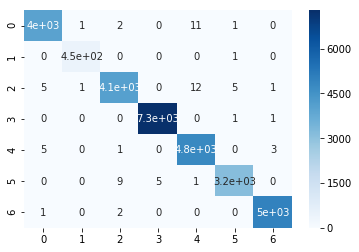

In [108]:
confusion = confusion_matrix(ans_final, pre_final)
print(confusion)
import seaborn as sns
sns.heatmap(confusion, annot=True, cmap='Blues')


[[9.96e-01 2.47e-04 4.95e-04 0.00e+00 2.72e-03 2.47e-04 0.00e+00]
 [0.00e+00 9.98e-01 0.00e+00 0.00e+00 0.00e+00 2.24e-03 0.00e+00]
 [1.21e-03 2.41e-04 9.94e-01 0.00e+00 2.90e-03 1.21e-03 2.41e-04]
 [0.00e+00 0.00e+00 0.00e+00 1.00e+00 0.00e+00 1.37e-04 1.37e-04]
 [1.04e-03 0.00e+00 2.08e-04 0.00e+00 9.98e-01 0.00e+00 6.23e-04]
 [0.00e+00 0.00e+00 2.84e-03 1.58e-03 3.15e-04 9.95e-01 0.00e+00]
 [2.01e-04 0.00e+00 4.01e-04 0.00e+00 0.00e+00 0.00e+00 9.99e-01]]


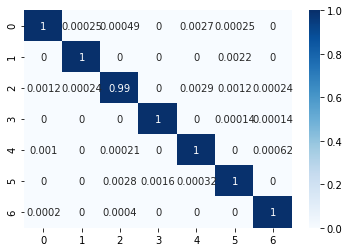

In [109]:
row_sums = confusion.sum(axis=1)
confusion=np.array(confusion,dtype=float)
for idx in range(confusion.shape[0]):
    for idy in range(confusion.shape[0]):
        #print(float(row_sums[idx]))
        confusion[idx][idy]/=float(row_sums[idx])
confusion = np.around(confusion,decimals=8)
print(confusion)
sns.heatmap(confusion, annot=True, cmap='Blues')

In [110]:
with open("reconstru_result.csv","w") as f:
    print("id,label", file = f)
    for id,label in enumerate(ans_final):
        print("{},{}".format(id,label) ,file = f)